In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import gc
from tqdm import tqdm, tqdm_notebook
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score
from mlxtend.regressor import StackingCVRegressor
import datetime
import time
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
%matplotlib inline

# baseline

## 读取数据&数据集说明
1. [训练集]历史销量数据：train_sales_data_v1.csv

|字段名称|	字段类型	|字段说明
|--|--|--|
|province	|String|	省份|
|adcode	int	省份编码
|model|	String|	车型编码|
|bodyType|	String|	车身类型|
|regYear|	int|	年|
|regMonth|	int|	月|
|salesVolume|	int|	销量|

2. [训练集]车型搜索数据：train_search_data_v1.csv

|字段名称|	字段类型	|字段说明
|--|--|--|
|province|	String|	省份|
|adcode|	int|	省份编码|
|model|	String|	车型编码|
|regYear|	int|	年|
|regMonth|	int|	月|
|popularity|	int|	搜索量|

3. [训练集]汽车垂直媒体新闻评论数据和车型评论数据：train_user_reply_data_v1.csv

该数据集包含了垂直媒体中，各车型的每月（不分地域）论坛发帖数据、每月新闻评论数据、车型下的评论数据三部分，这三个数据没有任何包含关系。

|字段名称|	字段类型	|字段说明
|--|--|--|
|model|	String|	车型编码|
|regYear|	int|	年|
|regMonth|	int|	月|
|newsReplyVolum|	int|	对车型相关新闻文章的评论数量|
|carCommentVolum|	int|	对车型的评价数量|

4. [评测集]2018年1月至4月的各车型各省份销量预测：evaluation_public.csv

|字段名称|	字段类型	|字段说明|
|--|--|--|
|id|	int|	数据的唯一标识，不可更改|
|province|	String|	省份|
|adcode|	int|	省份编码改|
|model|	String|	车型编码|
|bodyType|	String|	车身类型|
|regYear|	int|	年|
|regMonth|	int|	月|
|forecastVolum|	int|	预测销量，参赛队伍使用建立的模型得出的销量预测结果|

In [161]:
path  = './ccf_car/'

train_sales  = pd.read_csv(path+'train_sales_data.csv')#历史销量数据
train_search = pd.read_csv(path+'train_search_data.csv')#车型搜索数据
train_user   = pd.read_csv(path+'train_user_reply_data.csv')#汽车垂直媒体新闻评论数据和车型评论数据

evaluation_public = pd.read_csv(path+'evaluation_public.csv')#2018年1月至4月的各车型各省份销量预测
submit_example    = pd.read_csv(path+'submit_example.csv')

## 规则解决方案

In [4]:
m1_12    = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==12), 'salesVolume'].values
m1_11    = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==11), 'salesVolume'].values
m1_10    = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==10), 'salesVolume'].values
m1_09    = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==9) , 'salesVolume'].values
m1_08    = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==8) , 'salesVolume'].values

m1_12_volum = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==12), 'salesVolume'].values * m1_12
m1_11_volum = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==11), 'salesVolume'].values * m1_11
m1_10_volum = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==10), 'salesVolume'].values * m1_10
m1_09_volum = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==9) , 'salesVolume'].values * m1_09
m1_08_volum = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==8) , 'salesVolume'].values * m1_08

evaluation_public.loc[evaluation_public.regMonth==1, 'forecastVolum'] =  m1_12_volum/2 + m1_11_volum/4 + m1_10_volum/8 + m1_09_volum/16 + m1_08_volum/16

In [5]:
m16_1_2  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==2) , 'salesVolume'].values
m16_1_3  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==3) , 'salesVolume'].values
m16_1_4  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==4) , 'salesVolume'].values
m16_1_5  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==5) , 'salesVolume'].values

m16_2_3  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==3) , 'salesVolume'].values
m16_2_4  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==4) , 'salesVolume'].values
m16_2_5  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==5) , 'salesVolume'].values
m16_2_6  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==6) , 'salesVolume'].values

m16_3_4  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==4) , 'salesVolume'].values
m16_3_5  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==5) , 'salesVolume'].values
m16_3_6  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==6) , 'salesVolume'].values
m16_3_7  = train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2016)&(train_sales.regMonth==7) , 'salesVolume'].values

m17_1_2  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==2) , 'salesVolume'].values
m17_1_3  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values
m17_1_4  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==4) , 'salesVolume'].values
m17_1_5  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==5) , 'salesVolume'].values


m17_2_3  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values
m17_2_4  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==4) , 'salesVolume'].values
m17_2_5  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==5) , 'salesVolume'].values
m17_2_6  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==2) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==6) , 'salesVolume'].values

m17_3_4  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==4) , 'salesVolume'].values
m17_3_5  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==5) , 'salesVolume'].values
m17_3_6  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==6) , 'salesVolume'].values
m17_3_7  = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values / train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==7) , 'salesVolume'].values

m16_1 = m16_1_2/2 + m16_1_3/4 + m16_1_4/8 + m16_1_5/8
m16_2 = m16_2_3/2 + m16_2_4/4 + m16_2_5/8 + m16_2_6/8
m16_3 = m16_3_4/2 + m16_3_5/4 + m16_3_6/8 + m16_3_7/8

m17_1 = m17_1_2/2 + m17_1_3/4 + m17_1_4/8 + m17_1_5/8
m17_2 = m17_2_3/2 + m17_2_4/4 + m17_2_5/8 + m17_2_6/8
m17_3 = m17_3_4/2 + m17_3_5/4 + m17_3_6/8 + m17_3_7/8

m1 = m16_1 * 0.4 +  m17_1 * 0.6
m2 = m16_2 * 0.4 +  m17_2 * 0.6
m3 = m16_3 * 0.4 +  m17_3 * 0.6

evaluation_public.loc[evaluation_public.regMonth==2, 'forecastVolum'] = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==1) , 'salesVolume'].values / m1
evaluation_public.loc[evaluation_public.regMonth==3, 'forecastVolum'] = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==2) , 'salesVolume'].values / m2
evaluation_public.loc[evaluation_public.regMonth==4, 'forecastVolum'] = train_sales.loc[(train_sales.regYear==2017)&(train_sales.regMonth==3) , 'salesVolume'].values / m3

In [7]:
print(train_sales.loc[(train_sales.regMonth<=4) ,'salesVolume'].mean())
print(evaluation_public['forecastVolum'].mean())
evaluation_public[['id','forecastVolum']].round().astype(int).to_csv('ccf_car_sales.csv', index=False)

524.1121212121212
477.4628274411716


## 模型解决方案

In [162]:
data = pd.concat([train_sales, evaluation_public], ignore_index=True)#合并训练集和测试集
data = data.merge(train_search, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])#将搜索数据与销量数据融合
data = data.merge(train_user, 'left', on=['model', 'regYear', 'regMonth'])#将评论数据与销量数据、搜索数据融合
data['label'] = data['salesVolume']#训练集的销量->label
data['id'] = data['id'].fillna(0).astype(int)#训练集的数据没有id，全部补零（测试集有id，范围为0~5368），id是最后需要提交的两列数据之一（另一个是forecastVolum）
del data['salesVolume'], data['forecastVolum']#salesVolume->label,forecastVolum目前全为0没有意义，故删去

num_feat = ['adcode', 'regMonth', 'regYear', 'popularity', 'carCommentVolum', 'newsReplyVolum']#number_feature数字特征
cate_feat = ['bodyType', 'model', 'province']#categlory_feature类别特征

for i in cate_feat:
    data[i] = data[i].astype('category')#都转化为类别类型
features = num_feat + cate_feat#所有特征=数字特征+类别特征

In [163]:
from sklearn.metrics import mean_squared_error as mse
def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb'):
    if 'sample_weight' not in data.keys():
        data['sample_weight'] = 1
    model.random_state = random_state
    predict_label = 'predict_' + label#设定需要预测量的标签
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)#K折验证
    data[predict_label] = 0#设定预测量的初始值
    test_index = (data[label].isnull()) | (data[label] == -1)#获得测试集索引，测试集的label都为NaN，所以利用data[label].isnull()实现索引
    train_data = data[~test_index].reset_index(drop=True)#获得训练集数据
    test_data = data[test_index]#获得测试集

    for train_idx, val_idx in kfold.split(train_data):#对训练集的K折分别训练
        model.random_state = model.random_state + 1
        #划分训练集
        train_x = train_data.loc[train_idx][feature]
        train_y = train_data.loc[train_idx][label]
        #划分测试集
        test_x = train_data.loc[val_idx][feature]
        test_y = train_data.loc[val_idx][label]
        if model_type == 'lgb':#LightGBM
            try:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          # callbacks=[lgb.reset_parameter(learning_rate=lambda iter: max(0.005, 0.5 * (0.99 ** iter)))],
                          categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)
            except:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          # callbacks=[lgb.reset_parameter(learning_rate=lambda iter: max(0.005, 0.5 * (0.99 ** iter)))],
                          # categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)
        elif model_type == 'ctb':#CatBoost
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                      # eval_metric='mae',
                      # callbacks=[lgb.reset_parameter(learning_rate=lambda iter: max(0.005, 0.5 * (0.99 ** iter)))],
                      cat_features=cate_feature,
                      sample_weight=train_data.loc[train_idx]['sample_weight'],
                      verbose=100)
        train_data.loc[val_idx, predict_label] = model.predict(test_x)#预测交叉验证中的验证集，获得最终结果，用于后续loss结果评估
        if len(test_data) != 0:
            test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])#叠加
    test_data[predict_label] = test_data[predict_label] / n_splits#平均获得最终结果
    print(mse(train_data[label], train_data[predict_label]) * 5, train_data[predict_label].mean(),
          test_data[predict_label].mean())

    return pd.concat([train_data, test_data], sort=True, ignore_index=True), predict_label

In [165]:
lgb_model = lgb.LGBMRegressor(
    num_leaves=32, reg_alpha=0., reg_lambda=0.01, objective='mse', metric='mae',
    max_depth=-1, learning_rate=0.05, min_child_samples=20,
    n_estimators=1000, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
)#定义LightGBM模型
data, predict_label = get_predict_w(lgb_model, data, label='label',
                                    feature=features, cate_feature=cate_feat,
                                    random_state=2019, n_splits=5)#训练获得结果data和label

data['lgb'] = data[predict_label]#重命名结果标签

data['forecastVolum'] = data['lgb'].apply(lambda x: 0 if x < 0 else x)#<0的结果变为0
data[data.label.isnull()][['id', 'forecastVolum']].round().astype(int).to_csv('ccf_car_sales_lgb.csv', index=False)#输出

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 167.527
[200]	valid_0's l1: 133.839
[300]	valid_0's l1: 116.699
[400]	valid_0's l1: 107.595
[500]	valid_0's l1: 101.532
[600]	valid_0's l1: 97.285
[700]	valid_0's l1: 94.0742
[800]	valid_0's l1: 91.5989
[900]	valid_0's l1: 89.6032
[1000]	valid_0's l1: 88.1026
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 88.1026
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 171.106
[200]	valid_0's l1: 134.048
[300]	valid_0's l1: 117.574
[400]	valid_0's l1: 109.858
[500]	valid_0's l1: 104.082
[600]	valid_0's l1: 100.278
[700]	valid_0's l1: 97.424
[800]	valid_0's l1: 95.0868
[900]	valid_0's l1: 93.3413
[1000]	valid_0's l1: 91.9314
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 91.9314
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 175.722
[200]	valid_0's l1: 139.49
[300]	valid_0's l1: 121.311
[400]	valid_0'

# Improve

## 数据探索

In [46]:
data.sample(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label
35247,110000,NaN,3612,97f15de12cfabbd5,北京,3,2018,NaN,NaN,NaN,NaN
10498,510000,Sedan,0,d0f245b8781e3631,四川,8,2016,8642.0,339.0,3060.0,855.0
13874,330000,Sedan,0,6858d6dfe680bdf7,浙江,11,2016,8083.0,600.0,2292.0,1465.0
9856,310000,SUV,0,bb9fbec9a2833839,上海,8,2016,3146.0,21.0,2392.0,528.0
6413,360000,SUV,0,54fc07138d70374c,江西,5,2016,1175.0,24.0,8159.0,222.0
2148,330000,Sedan,0,0797526c057dcf5b,浙江,2,2016,942.0,13.0,5941.0,268.0
22508,150000,Sedan,0,a28bb927b6fcb33c,内蒙古,6,2017,265.0,443.0,150.0,117.0
25185,350000,MPV,0,17bc272c93f19d56,福建,8,2017,1901.0,30.0,3824.0,402.0
7800,130000,SUV,0,fc32b1a017b34efe,河北,6,2016,4241.0,38.0,333.0,614.0
13393,350000,SUV,0,af6f4f548684e14d,福建,11,2016,2360.0,289.0,5804.0,767.0


In [47]:
data.shape

(36960, 11)

In [5]:
data_after=data.copy()
data_after.head()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0


In [6]:
data_before=data.copy()
data_before.head()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0


In [7]:
data_before.to_csv('data_before.csv')

常用统计量观察

In [8]:
import pandas_profiling
from pathlib import Path
profile=data_before.profile_report(title='CCF Car')
profile.to_file(output_file=Path('./databefore.html'))

经观察数字类型数据都是偏态，进行对数变换

In [139]:
skewness=['carCommentVolum','label','newsReplyVolum','popularity']#偏态

In [140]:
for x in skewness:
    data[x+'_log']=np.log1p(data[x])
data.head()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,2.484907,5.680173,4.672829,7.299797
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,2.484907,6.146329,4.672829,7.374629
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,2.484907,5.552960,4.672829,7.299797
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,2.484907,6.013715,4.672829,7.771067
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,2.484907,6.415097,4.672829,8.178358


In [50]:
# 偏度矫正
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in data.columns:
    if data[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = data[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

In [51]:
#以0.5作为基准，统计偏度超过此数值的高偏度分布数据列，获取这些数据列的index。
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

#对高偏度数据进行处理，将其转化为正态分布。
#Box和Cox提出的变换可以使线性回归模型满足线性性、独立性、方差齐次以及正态性的同时，又不丢失信息。
for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))#这是boxcox1p的使用方法，参数的具体意义暂时不解释

In [98]:
data.shape

(36960, 15)

## 特征删除与融合

In [13]:
data.head()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log
0,310000,SUV,0.0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,2.484907,5.680173,4.672829,7.299797
1,530000,SUV,0.0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,2.484907,6.146329,4.672829,7.374629
2,150000,SUV,0.0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,2.484907,5.552960,4.672829,7.299797
3,110000,SUV,0.0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,2.484907,6.013715,4.672829,7.771067
4,510000,SUV,0.0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,2.484907,6.415097,4.672829,8.178358


In [142]:
# 给省份分类,依据https://www.daas-auto.com/newsDe/892.html
province1=['广东','江苏','山东','浙江','河南']
province2=['河北', '四川', '北京']
province3=['上海', '湖北', '湖南', '安徽']
province4=['辽宁', '云南', '陕西', '福建', '贵州','广西','山西','江西','重庆']
province5=['吉林', '黑龙江', '天津', '内蒙古', '新疆', '甘肃']
province6=['海南','宁夏','青海','西藏']

In [143]:
len(data.province.unique())

22

In [144]:
data['province_rank']='0'
for i in range(len(data)):
    if data['province'][i] in province1:
        data['province_rank'][i]='1'
    elif data['province'][i] in province2:
        data['province_rank'][i]='2'
    elif data['province'][i] in province3:
        data['province_rank'][i]='3'
    elif data['province'][i] in province4:
        data['province_rank'][i]='4'
    elif data['province'][i] in province5:
        data['province_rank'][i]='5'
    elif data['province'][i] in province6:
        data['province_rank'][i]='6'
    else:
        data['province_rank'][i]='0'
data.head()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,2.484907,5.680173,4.672829,7.299797,3
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,2.484907,6.146329,4.672829,7.374629,4
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,2.484907,5.552960,4.672829,7.299797,5
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,2.484907,6.013715,4.672829,7.771067,2
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,2.484907,6.415097,4.672829,8.178358,2


In [56]:
data.shape

(36960, 16)

In [17]:
data['regYear'].unique(),data['regMonth'].unique()

(array([2016, 2017, 2018], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64))

In [18]:
data.columns

Index(['adcode', 'bodyType', 'id', 'model', 'province', 'regMonth', 'regYear',
       'popularity', 'carCommentVolum', 'newsReplyVolum', 'label',
       'carCommentVolum_log', 'label_log', 'newsReplyVolum_log',
       'popularity_log', 'province_rank'],
      dtype='object')

In [102]:
# 时间分类
data['date_block_num']=0
tmp=pd.array([0]*len(data))
cnts=[]
for year in data['regYear'].unique():
    for month in data[data['regYear']==year]['regMonth'].unique():
        cnts.append(str(year)+'_'+str(month))
for i in range(len(data)):
    data['date_block_num'][i]=cnts.index(str(data['regYear'][i])+'_'+str(data['regMonth'][i]))+1
data.sample(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank,date_block_num
33361,450000,NaN,1704,63065128401bb3ff,广西,2,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,26
20977,360000,SUV,0,4f79773e600518a6,江西,4,2017,355.0,32.0,3.0,63.0,3.496508,4.158883,1.386294,5.874931,4,16
7581,410000,SUV,0,5b1c11c3efed5312,河南,6,2016,2715.0,61.0,27.0,565.0,4.127134,6.338594,3.332205,7.906915,1,6
17005,230000,Sedan,0,212083a9246d2fd3,黑龙江,1,2017,1431.0,167.0,13.0,102.0,5.123964,4.634729,2.639057,7.266827,5,13
3929,410000,Sedan,0,c6cd4e0e073f5ac2,河南,3,2016,2330.0,44.0,1532.0,1036.0,3.806662,6.944087,7.334982,7.754053,1,3
19946,330000,MPV,0,c06a2a387c0ee510,浙江,4,2017,1716.0,35.0,1962.0,915.0,3.583519,6.820016,7.582229,7.448334,1,16
7774,440000,SUV,0,4f79773e600518a6,广东,6,2016,2560.0,48.0,492.0,107.0,3.891820,4.682131,6.200509,7.848153,1,6
4119,340000,Sedan,0,7023efdab9cedc03,安徽,4,2016,1796.0,33.0,258.0,375.0,3.526361,5.929589,5.556828,7.493874,3,4
11569,500000,SUV,0,17363f08d683d52b,重庆,9,2016,1351.0,25.0,30.0,119.0,3.258097,4.787492,3.433987,7.209340,4,9
12645,350000,Sedan,0,dff803b4024d261d,福建,10,2016,356.0,289.0,62.0,397.0,5.669881,5.986452,4.143135,5.877736,4,10


In [103]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','province','model',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','province','model', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','province','model'], how='left')
    return df

In [104]:
ts = time.time()
data=lag_feature(data,[1,2,3,6,12],'label')
time.time() - ts

0.0897512435913086

In [105]:
data.shape

(36960, 22)

In [106]:
data.sample(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank,date_block_num,label_lag_1,label_lag_2,label_lag_3,label_lag_6,label_lag_12
33633,350000,NaN,1976,bb9fbec9a2833839,福建,2,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,26,NaN,287.0,311.0,280.0,110.0
11568,210000,SUV,0,17363f08d683d52b,辽宁,9,2016,2552.0,25.0,30.0,239.0,3.258097,5.480639,3.433987,7.845024,4,9,236.0,211.0,186.0,206.0,NaN
35388,130000,NaN,3753,c6833cb891626c17,河北,3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,27,NaN,NaN,1451.0,870.0,412.0
29573,340000,SUV,0,5d7fb682edd0f937,安徽,11,2017,1302.0,58.0,701.0,232.0,4.077537,5.451038,6.553933,7.172425,3,23,180.0,219.0,222.0,210.0,169.0
16669,420000,Sedan,0,0797526c057dcf5b,湖北,1,2017,1496.0,147.0,2451.0,736.0,4.997212,6.602588,7.804659,7.311218,3,13,1562.0,1425.0,1120.0,689.0,786.0
1787,340000,Hatchback,0,7a7885e2d7c00bcf,安徽,2,2016,1200.0,275.0,335.0,357.0,5.620401,5.880533,5.817111,7.090910,3,2,569.0,NaN,NaN,NaN,NaN
13,410000,SUV,0,3c974920a76ac9c1,河南,1,2016,3483.0,11.0,106.0,537.0,2.484907,6.287859,4.672829,8.155936,1,1,NaN,NaN,NaN,NaN,NaN
18453,350000,Sedan,0,c6cd4e0e073f5ac2,福建,2,2017,583.0,174.0,746.0,74.0,5.164786,4.317488,6.616065,6.369901,4,14,173.0,431.0,291.0,243.0,107.0
4373,350000,Sedan,0,cd5841d44fd7625e,福建,4,2016,937.0,26.0,9923.0,229.0,3.295837,5.438079,9.202711,6.843750,4,4,288.0,162.0,492.0,NaN,NaN
18741,500000,Sedan,0,7245e0ee27b195cd,重庆,3,2017,867.0,376.0,37.0,238.0,5.932245,5.476464,3.637586,6.766192,4,15,142.0,296.0,402.0,325.0,141.0


In [107]:
ts = time.time()
group = data.groupby(['date_block_num']).agg({'label': ['mean']})
group.columns = [ 'date_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num'], how='left')
data['date_avg_label'] = data['date_avg_label'].astype(np.float16)
data = lag_feature(data, [1], 'date_avg_label')
data.drop(['date_avg_label'], axis=1, inplace=True)
time.time() - ts

0.05585312843322754

In [108]:
data.shape

(36960, 23)

In [109]:
data.sample()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank,date_block_num,label_lag_1,label_lag_2,label_lag_3,label_lag_6,label_lag_12,date_avg_label_lag_1
17185,110000,Sedan,0,3d7554f1f56dd664,北京,2,2017,4383.0,714.0,3722.0,359.0,6.572283,5.886104,8.222285,8.385717,2,14,368.0,811.0,675.0,464.0,209.0,573.0


In [110]:
ts = time.time()
group = data.groupby(['date_block_num', 'province']).agg({'label': ['mean']})
group.columns = [ 'date_province_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','province'], how='left')
data['date_province_avg_label'] = data['date_province_avg_label'].astype(np.float16) 
data = lag_feature(data, [1,2,3,6,12], 'date_province_avg_label')
data.drop(['date_province_avg_label'], axis=1, inplace=True)
time.time() - ts

0.13366055488586426

In [111]:
data.shape

(36960, 28)

In [112]:
data.sample(5)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank,date_block_num,label_lag_1,label_lag_2,label_lag_3,label_lag_6,label_lag_12,date_avg_label_lag_1,date_province_avg_label_lag_1,date_province_avg_label_lag_2,date_province_avg_label_lag_3,date_province_avg_label_lag_6,date_province_avg_label_lag_12
16099,350000,Sedan,0,7245e0ee27b195cd,福建,1,2017,878.0,261.0,39.0,249.0,5.568345,5.521461,3.688879,6.778785,4,13,420.0,239.0,218.0,218.0,201.0,984.0,582.00,481.25,407.750,366.5,516.0
12782,310000,SUV,0,fde95ea242abd896,上海,10,2016,1633.0,31.0,3275.0,260.0,3.465736,5.564520,8.094378,7.398786,3,10,237.0,233.0,222.0,297.0,NaN,694.5,452.50,404.75,367.000,370.5,NaN
5980,210000,MPV,0,79de4e4b24c35b04,辽宁,5,2016,2733.0,146.0,2709.0,383.0,4.990433,5.950643,7.904704,7.913521,4,5,398.0,377.0,214.0,NaN,NaN,524.5,435.25,418.75,231.125,NaN,NaN
13764,330000,SUV,0,a207df29ec9583f0,浙江,11,2016,3100.0,87.0,1239.0,849.0,4.477337,6.745236,7.122867,8.039480,1,11,733.0,834.0,880.0,723.0,NaN,624.0,986.50,1022.00,964.000,883.5,NaN
5133,140000,SUV,0,4f79773e600518a6,山西,4,2016,847.0,39.0,22.0,103.0,3.688879,4.644391,3.135494,6.742881,4,4,100.0,58.0,228.0,NaN,NaN,542.5,299.75,203.75,487.500,NaN,NaN


In [113]:
ts = time.time()
group = data.groupby(['date_block_num', 'model']).agg({'label': ['mean']})
group.columns = [ 'date_model_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','model'], how='left')
data['date_model_avg_label'] = data['date_model_avg_label'].astype(np.float16) 
data = lag_feature(data, [1,2,3,6,12], 'date_model_avg_label')
data.drop(['date_model_avg_label'], axis=1, inplace=True)
time.time() - ts

0.12968111038208008

In [114]:
data.shape

(36960, 33)

In [115]:
ts = time.time()
group = data.groupby(['date_block_num', 'adcode']).agg({'label': ['mean']})
group.columns = [ 'date_adcode_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','adcode'], how='left')
data['date_adcode_avg_label'] = data['date_adcode_avg_label'].astype(np.float16) 
data = lag_feature(data, [1,2,3,6,12], 'date_adcode_avg_label')
data.drop(['date_adcode_avg_label'], axis=1, inplace=True)
time.time() - ts

0.14463138580322266

In [116]:
data.shape

(36960, 38)

In [117]:
data.sample()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank,date_block_num,label_lag_1,label_lag_2,label_lag_3,label_lag_6,label_lag_12,date_avg_label_lag_1,date_province_avg_label_lag_1,date_province_avg_label_lag_2,date_province_avg_label_lag_3,date_province_avg_label_lag_6,date_province_avg_label_lag_12,date_model_avg_label_lag_1,date_model_avg_label_lag_2,date_model_avg_label_lag_3,date_model_avg_label_lag_6,date_model_avg_label_lag_12,date_adcode_avg_label_lag_1,date_adcode_avg_label_lag_2,date_adcode_avg_label_lag_3,date_adcode_avg_label_lag_6,date_adcode_avg_label_lag_12
29639,340000,Sedan,0,ef76a85c4b39f693,安徽,11,2017,4832.0,2.0,514.0,464.0,1.098612,6.142037,6.244167,8.483223,3,23,402.0,565.0,453.0,271.0,219.0,616.5,558.0,574.5,544.0,444.75,653.5,454.5,641.5,552.5,391.75,253.5,558.0,574.5,544.0,444.75,653.5


In [118]:
ts = time.time()
group = data.groupby(['date_block_num', 'model','province']).agg({'label': ['mean']})
group.columns = [ 'date_model_province_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','model','province'], how='left')
data['date_model_province_avg_label'] = data['date_model_province_avg_label'].astype(np.float16) 
data = lag_feature(data, [1], 'date_model_province_avg_label')
data.drop(['date_model_province_avg_label'], axis=1, inplace=True)
time.time() - ts

0.09078288078308105

In [119]:
data.shape

(36960, 39)

In [120]:
data.sample()

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,carCommentVolum_log,label_log,newsReplyVolum_log,popularity_log,province_rank,date_block_num,label_lag_1,label_lag_2,label_lag_3,label_lag_6,label_lag_12,date_avg_label_lag_1,date_province_avg_label_lag_1,date_province_avg_label_lag_2,date_province_avg_label_lag_3,date_province_avg_label_lag_6,date_province_avg_label_lag_12,date_model_avg_label_lag_1,date_model_avg_label_lag_2,date_model_avg_label_lag_3,date_model_avg_label_lag_6,date_model_avg_label_lag_12,date_adcode_avg_label_lag_1,date_adcode_avg_label_lag_2,date_adcode_avg_label_lag_3,date_adcode_avg_label_lag_6,date_adcode_avg_label_lag_12,date_model_province_avg_label_lag_1
6628,370000,Sedan,0,3d7554f1f56dd664,山东,6,2016,3037.0,108.0,3230.0,862.0,4.691348,6.760415,8.080547,8.018955,1,6,977.0,1100.0,807.0,NaN,NaN,579.5,1107.0,1070.0,926.5,NaN,NaN,1163.0,994.5,1103.0,NaN,NaN,1107.0,1070.0,926.5,NaN,NaN,977.0


In [121]:
ts = time.time()
group = data.groupby(['date_block_num', 'model','adcode']).agg({'label': ['mean']})
group.columns = [ 'date_model_adcode_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','model','adcode'], how='left')
data['date_model_adcode_avg_label'] = data['date_model_adcode_avg_label'].astype(np.float16) 
data = lag_feature(data, [1], 'date_model_adcode_avg_label')
data.drop(['date_model_adcode_avg_label'], axis=1, inplace=True)
time.time() - ts

0.08580398559570312

In [122]:
data.shape

(36960, 40)

In [123]:
ts = time.time()
group = data.groupby(['date_block_num', 'province','adcode']).agg({'label': ['mean']})
group.columns = [ 'date_province_adcode_avg_label' ]
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','province','adcode'], how='left')
data['date_province_adcode_avg_label'] = data['date_province_adcode_avg_label'].astype(np.float16) 
data = lag_feature(data, [1], 'date_province_adcode_avg_label')
data.drop(['date_province_adcode_avg_label'], axis=1, inplace=True)
time.time() - ts

0.1765279769897461

In [124]:
data.shape

(36960, 41)

In [145]:
data.columns

Index(['adcode', 'bodyType', 'id', 'model', 'province', 'regMonth', 'regYear',
       'popularity', 'carCommentVolum', 'newsReplyVolum', 'label',
       'carCommentVolum_log', 'label_log', 'newsReplyVolum_log',
       'popularity_log', 'province_rank'],
      dtype='object')

## 训练

In [157]:
num_feat = ['adcode', 'id', 'regMonth', 'regYear',
       'popularity', 'carCommentVolum', 'newsReplyVolum', 'label',
       'carCommentVolum_log', 'label_log', 'newsReplyVolum_log',
       'popularity_log']#number_feature数字特征
cate_feat = ['bodyType', 'model', 'province', 'province_rank']#categlory_feature类别特征

for i in cate_feat:
    data[i] = data[i].astype('category')#都转化为类别类型
features = num_feat + cate_feat#所有特征=数字特征+类别特征

In [158]:
from sklearn.metrics import mean_squared_error as mse
def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb'):
    if 'sample_weight' not in data.keys():
        data['sample_weight'] = 1
    model.random_state = random_state
    predict_label = 'predict_' + label#设定需要预测量的标签
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)#K折验证
    data[predict_label] = 0#设定预测量的初始值
    test_index = data[label].isnull()#(data[label].isnull()) | (data[label] == -1)#获得测试集索引，测试集的label都为NaN，所以利用data[label].isnull()实现索引
    train_data = data[~test_index].reset_index(drop=True)#获得训练集数据
    test_data = data[test_index]#获得测试集

    for train_idx, val_idx in kfold.split(train_data):#对训练集的K折分别训练
        model.random_state = model.random_state + 1
        #划分训练集
        train_x = train_data.loc[train_idx][feature]
        train_y = train_data.loc[train_idx][label]
        #划分测试集
        test_x = train_data.loc[val_idx][feature]
        test_y = train_data.loc[val_idx][label]
        if model_type == 'lgb':#LightGBM
            try:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          # callbacks=[lgb.reset_parameter(learning_rate=lambda iter: max(0.005, 0.5 * (0.99 ** iter)))],
                          categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)
            except:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          # callbacks=[lgb.reset_parameter(learning_rate=lambda iter: max(0.005, 0.5 * (0.99 ** iter)))],
                          # categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)
        elif model_type == 'ctb':#CatBoost
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                      # eval_metric='mae',
                      # callbacks=[lgb.reset_parameter(learning_rate=lambda iter: max(0.005, 0.5 * (0.99 ** iter)))],
                      cat_features=cate_feature,
                      sample_weight=train_data.loc[train_idx]['sample_weight'],
                      verbose=100)
        train_data.loc[val_idx, predict_label] = model.predict(test_x)#预测交叉验证中的验证集，获得最终结果，用于后续loss结果评估
        if len(test_data) != 0:
            test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])#叠加
    test_data[predict_label] = test_data[predict_label] / n_splits#平均获得最终结果
    print(mse(train_data[label], train_data[predict_label]) * 5, train_data[predict_label].mean(),
          test_data[predict_label].mean())

    return pd.concat([train_data, test_data], sort=True, ignore_index=True), predict_label

In [159]:
lgb_model = lgb.LGBMRegressor(
    num_leaves=32, reg_alpha=0., reg_lambda=0.01, objective='mse', metric='mae',
    max_depth=-1, learning_rate=0.05, min_child_samples=20,
    n_estimators=1000, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
)#定义LightGBM模型
data, predict_label = get_predict_w(lgb_model, data, label='label',
                                    feature=features, cate_feature=cate_feat,
                                    random_state=2019, n_splits=5)#训练获得结果data和label

data['lgb'] = data[predict_label]#重命名结果标签

data['forecastVolum'] = data['lgb'].apply(lambda x: 0 if x < 0 else x)#<0的结果变为0
data[data.label.isnull()][['id', 'forecastVolum']].round().astype(int).to_csv('sales_feature_engineer_rough.csv', index=False)#输出

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 41.7002
[200]	valid_0's l1: 27.4215
[300]	valid_0's l1: 23.3523
[400]	valid_0's l1: 21.5337
[500]	valid_0's l1: 20.4524
[600]	valid_0's l1: 19.7503
[700]	valid_0's l1: 19.2406
[800]	valid_0's l1: 18.8625
[900]	valid_0's l1: 18.5806
[1000]	valid_0's l1: 18.3454
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 18.3454
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 41.1447
[200]	valid_0's l1: 26.4385
[300]	valid_0's l1: 22.6891
[400]	valid_0's l1: 21.2902
[500]	valid_0's l1: 20.231
[600]	valid_0's l1: 19.4664
[700]	valid_0's l1: 19.0913
[800]	valid_0's l1: 18.7956
[900]	valid_0's l1: 18.4799
[1000]	valid_0's l1: 18.3117
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 18.3112
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 24.1407
[200]	valid_0's l1: 16.5309
[300]	valid_0's l1: 15.0564
[400]	valid_0

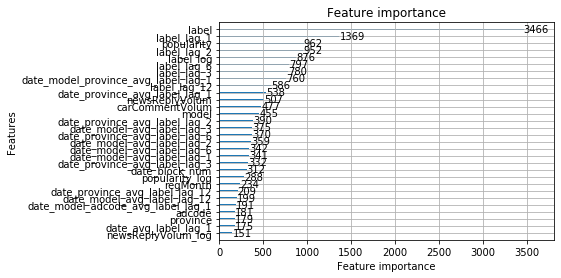

In [135]:
lgb.plot_importance(lgb_model, max_num_features=30)

In [166]:
result=pd.read_csv('sales_feature_engineer_rough.csv')
result['forecastVolum']*=10
result[['id', 'forecastVolum']].round().astype(int).to_csv('sales_feature_engineer_x10.csv', index=False)#输出